### 몬테카를로 시뮬레이션의 활용
 - 옵션, 파생상품 등의 조건부 청구권의 가치 평가
   - 조건부 청구권의 가치 : 위험 중립 or 마틴게일 측도 하에서 기대 페이오프를 현재가치화 한것
     - 위험 중립 측도 : 주식, 지수 등의 모든 위험 요인이 무위험 단기 이자율에 따라 증가하도록 하는 확률 측도

# 10.3.1 European Option
 - 만기 Pay-Off : $h(S_T) ≡ max(S_T -K, 0)$

 - 위험 중립 기대값을 사용한 가격결정
 
   - $C_0 = e^{-rT}E^Q_0(h(S_T)) = e^{-rT}∫^∞_0h(s)q(s)ds$
  
  
  - -> 위험 중립 몬테카를로 추정법
  
    - $C_0 = e^{-rT}{1 \over I}∑^I_{i = 1}h(S^i_T)$

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# chap 10_2 표준정규분포 따르는 난수 생성함수
def gen_sn(M, i, anti_paths = True, mo_match = True):
    
    if anti_paths == True:
        sn = npr.standard_normal((M + 1, int(i/2)))
        sn = np.concatenate((sn, -sn), axis = 1)
    
    else:
        sn = npr.standard_normal((M + 1, i))
    
    if mo_match == True:
        sn = (sn - sn.mean()) / sn.std()
    
    return sn

In [3]:
S0 = 100.
r = 0.05
sig = 0.25
T = 1.0
i = 50000

In [4]:
# 만기 주가만을 시뮬레이션
def gbm_mcs_stat(K):
    
    sn = gen_sn(1,i)                              # 난수 생성
    ST = S0 * np.exp((r - 0.5 * sig ** 2) * T     
                    + sig * np.sqrt(T) * sn[1])   # 만기 주가 시뮬레이션
    hT = np.maximum(ST - K, 0)                    # 만기 pay-off
    C0 = np.exp(-r * T) * 1 / i * np.sum(hT)      # 몬테카를로 추정
    
    return C0

In [5]:
# 행사가 105인 Call Option

gbm_mcs_stat(105.)

10.01781164790435

In [6]:
# 동적 시뮬레이션 ( 주가 path 시뮬레이션 )

M = 50

def gbm_mcs_dyna(K, option = 'call'):
    
    dt = T / M
    S = np.zeros((M + 1, i))
    S[0] = S0
    sn = gen_sn(M, i)
    
    for t in range(1, M + 1):
        S[t] = S[t - 1] * np.exp((r - 0.5 * sig ** 2) * dt
                                + sig * np.sqrt(dt) * sn[t])
    
    if option == 'call':
        hT = np.maximum(S[-1] - K, 0)
    
    else:
        hT = np.maximum(K - S[-1], 0)
    
    C0 = np.exp(-r * T) * 1 / i * np.sum(hT)
    
    return C0

In [7]:
# 행사가 110인 Call Option
print(gbm_mcs_dyna(K = 110., option = 'call'))

# 행사가 110인 Put Option
print(gbm_mcs_dyna(K = 110., option = 'put'))

8.043498669995227
12.635046523368766


시뮬레이션을 통해 추정한 가격과 블랙-숄즈 가치 평가 공식으로 계산한 가격의 차이가 얼마나 나는지가 중요

In [8]:
# 블랙-숄즈 공식

from scipy import stats

def bsm_call_value(S0, K, T, r, sig): # 블랙-숄즈 공식
    
    d1 = (np.log(S0/K)+(r + 0.5 * sig ** 2) * T)/(sig * np.sqrt(T))
    d2 = (np.log(S0/K)+(r - 0.5 * sig ** 2) * T)/(sig * np.sqrt(T))
    value = S0 * stats.norm.cdf(d1,0.0,1.0) - np.exp(-r*T)*K*stats.norm.cdf(d2,0.0,1.0)
    
    return value

In [9]:
stat_res = []
dyna_res = []
anal_res = []
k_list = np.arange(80., 120.1, 5.) # 행사가 list
np.random.seed(200000)

for K in k_list:
    stat_res.append(gbm_mcs_stat(K))
    dyna_res.append(gbm_mcs_dyna(K))
    anal_res.append(bsm_call_value(S0, K, T, r, sig))

stat_res = np.array(stat_res)
dyna_res = np.array(dyna_res)
anal_res = np.array(anal_res)

#### 1. 정적 시뮬레이션 방식과 블랙-숄즈 공식 비교

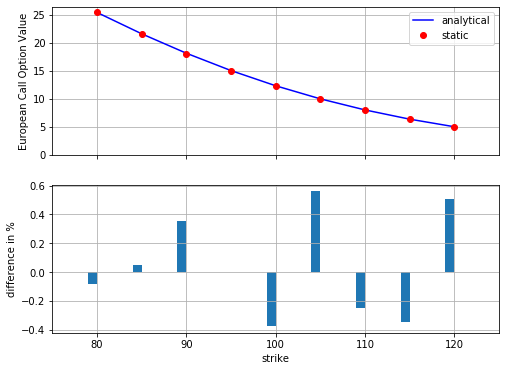

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize = (8, 6))
ax1.plot(k_list, anal_res, 'b', label = 'analytical')
ax1.plot(k_list, stat_res, 'ro', label = 'static')
ax1.set_ylabel('European Call Option Value')
ax1.grid(True)
ax1.legend(loc = 0)
ax1.set_ylim(ymin = 0)
wi = 1.0
ax2.bar(k_list - wi / 2, (anal_res - stat_res) / anal_res * 100, wi)
ax2.set_xlabel('strike')
ax2.set_ylabel('difference in %')
ax2.set_xlim(left = 75, right = 125)
ax2.grid(True)

#### 2. 동적 시뮬레이션 방식과 블랙-숄즈 공식 비교

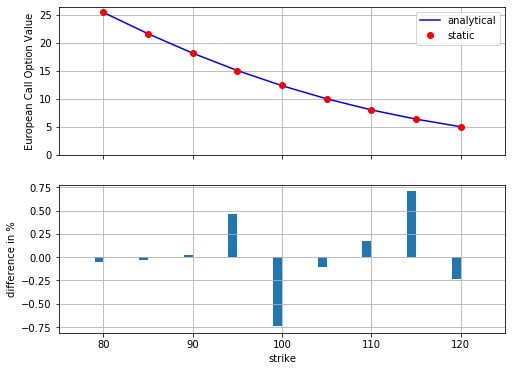

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize = (8, 6))
ax1.plot(k_list, anal_res, 'b', label = 'analytical')
ax1.plot(k_list, dyna_res, 'ro', label = 'static')
ax1.set_ylabel('European Call Option Value')
ax1.grid(True)
ax1.legend(loc = 0)
ax1.set_ylim(ymin = 0)
wi = 1.0
ax2.bar(k_list - wi / 2, (anal_res - dyna_res) / anal_res * 100, wi)
ax2.set_xlabel('strike')
ax2.set_ylabel('difference in %')
ax2.set_xlim(left = 75, right = 125)
ax2.grid(True)

#### 1,2번 방식 모두 오차가 절대값 1% 이하이며, 음의 오차와 양의 오차가 모두 존재한다.

#### & 몬테카를로 추정치의 품질 : 시간 간격 수(M)와 시뮬레이션 수(i)를 바꾸어 조절 가능

# 10.3.2 American Option
 - 최적 정지 문제 풀이 -> 시뮬레이션 상에서 이산 시간 그리드 사용
   - -> 아메리칸 옵션 X, 버뮤다 옵션 풀이 But, 시간 그리드 간격을 줄이면 아메리칸 옵션으로 수렴

 - 아메리칸 옵션 가격 계산을 위한 최적 정지 문제
   - $V_0 = sup_{\tau∈｛0,Δt,Δ2t...,T｝} e^{-rT}E^Q_0(h_\tau(S_\tau))$

####  최소 자승 몬테카를로 방법(LSM)

- 특정 시간 t에서 아메리칸 옵션 가치 : $V_t(s) = max(h_t(s), C_t(s))$
  - $C_t(s) = E^Q_t(e^{-rΔt}V_{t+Δt}(S_{t+Δt}) | S_t = s)$ : 주가 $S_t = s$에서 옵션 보유 가치
 
 
 - -> 주가를 M개의 동일한 시간 간격 $Δt$로 시뮬레이션한 경로가 있다고 가정 
   - -> $Y_{t,i} ≡ e^{-rΔt}V_{t+Δt,i}$는 t시간에서 경로 i에 대해 시뮬레이션한 보유가치 -> 다음 시간 단계의 보유가치를 모든 주가에 대해 알아야함
     - -> 최소 자승 회귀법 사용
     
   최소 자승 회귀법 
    - 기저 함수 집합 $b_d,d = 1,...,D$가 주어지면 보유 가치는 $C_{t,i} = ∑^D_{d = 1}\alpha^*_{d,t}·b_d(S_{t,i})$
      - $\alpha^*$는 $min_{\alpha_{1,t},...,\alpha_{D,t}}{1 \over I}∑^I_{i = 1}(Y_{t,i} - ∑^D_{d = 1}\alpha_{d,t}·b_d(S_{t,i}))^2$에 따른 최소 자승법으로 도출

In [12]:
def gbm_mcs_amer(K, option = 'call'):
    dt = T / M
    df = np.exp(-r * dt)
    S = np.zeros((M + 1, i))
    S[0] = S0
    sn = gen_sn(M, i)
    for t in range(1, M + 1):
        S[t] = S[t - 1] * np.exp((r - 0.5 * sig ** 2) * dt
                                + sig * np.sqrt(dt) * sn[t])
    
    if option == 'call':
        h = np.maximum(S - K, 0)
    
    else:
        h = np.maximum(K - S, 0)                        # 유형별 Pay-Off
    
    V = np.copy(h)
    for t in range(M - 1, 0, -1):
        reg = np.polyfit(S[t], df * V[t + 1], 7)       # 최소 자승 회귀법(9.1.1절 참고)
        C = np.polyval(reg, S[t])
        V[t] = np.where(C > h[t], V[t + 1] * df, h[t]) 
        
    C0 = df * 1 / i * np.sum(V[1])
    return C0

In [13]:
print(gbm_mcs_amer(110., option = 'call'))
print(gbm_mcs_amer(110., option = 'put'))

7.778933279449315
13.614023206242445


#### European과 American Put 비교

In [14]:
euro_res = []
amer_res = []
k_list = np.arange(80., 120.1, 5.)

for K in k_list:
    euro_res.append(gbm_mcs_dyna(K, 'put'))
    amer_res.append(gbm_mcs_amer(K, 'put'))

euro_res = np.array(euro_res)
amer_res = np.array(amer_res)

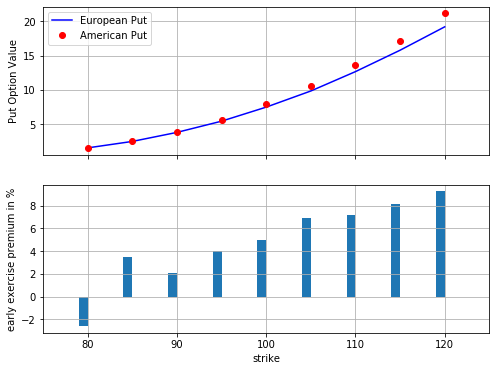

In [16]:
fig , (ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize = (8, 6))
ax1.plot(k_list, euro_res, 'b', label = 'European Put')
ax1.plot(k_list, amer_res, 'ro', label = 'American Put')
ax1.set_ylabel('Put Option Value')
ax1.grid(True)
ax1.legend(loc = 0)

wi = 1.0
ax2.bar(k_list - wi / 2, (amer_res - euro_res) / amer_res * 100, wi)
ax2.set_xlabel('strike')
ax2.set_ylabel('early exercise premium in %')
ax2.set_xlim(left = 75, right = 125)
ax2.grid(True)

조기 행사 프리미엄이 최대 약10%까지도 올라가는 것을 확인할 수 있다.